In [1]:
import matplotlib.pyplot as plt
import json
import glob
import re
import pandas as pd
import numpy as np

import qutip
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process

import multiprocessing
multiprocessing.set_start_method('spawn')

In [2]:
EJ = 3
EJoverEC = 6
EJoverEL = 25
EC = EJ / EJoverEC
EL = EJ / EJoverEL
n_lvls = 80
n_lvls_exp = 60
qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=n_lvls)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(n_lvls_exp)]

state_0_dressed = qutip.basis(qbt.truncated_dim, 1)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)

initial_states  = [
                state_0_dressed,
                state_1_dressed,
                ]

def do_experiment(amp, w_d, t_square,t_rise,plot=False):
    t_tot = t_square + 2*t_rise
    tlist = np.linspace(0, t_tot, 51)

    results = qbt.run_qutip_mesolve_parrallel(
                initial_states,
                [tlist],
                drive_terms=[[
                            DriveTerm(
                                driven_op=qutip.Qobj(
                                    qbt.fluxonium.n_operator(energy_esys=True)),
                                pulse_shape_func=square_pulse_with_rise_fall,
                                pulse_id='pi',
                                pulse_shape_args={
                                    "w_d": w_d,    # No extra 2pi factor
                                    "amp": amp,    # No extra 2pi factor
                                    't_square': t_square,
                                    "t_rise": t_rise,
                                },
                            )
                        ]],
                c_ops=None,
                e_ops=[e_ops],
    )[0]
    if plot:
        fig, axes = plt.subplots(1,2,figsize=(8,4))
        for exp_idx in range(len(e_ops)):
            axes[0].plot(tlist, results[0].expect[exp_idx],label= f"|{exp_idx}>")
        axes[0].set_yscale('log')

        for exp_idx in range(len(e_ops)):
            axes[1].plot(tlist, results[1].expect[exp_idx],label= f"|{exp_idx}>")
        axes[1].set_yscale('log')

    one_minus_pop2 = np.abs(1- results[0].expect[2][-1])
    one_minus_pop0 = np.abs(1- results[1].expect[1][-1])
    res = one_minus_pop2 + one_minus_pop0
    return res

0.005012023578052527

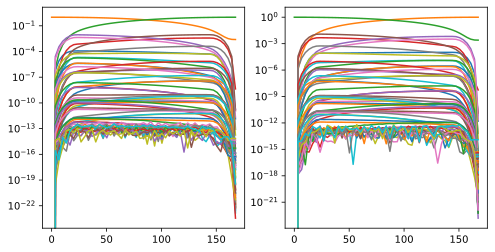

In [29]:
do_experiment(0.56679488, 0.00057526, 122.5, 22.5, plot=True)

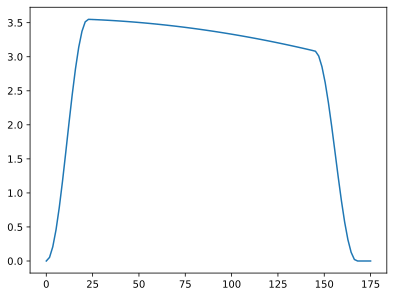

In [28]:
fig, ax = plt.subplots()
tlist = np.linspace(0, 175, 101)
pulse_shape = []
for t in tlist:
    pulse_shape.append(square_pulse_with_rise_fall(t,{
            "w_d":  0.00057526,    # No extra 2pi factor
            "amp": 0.56679488,    # No extra 2pi factor
            't_square': 122.5,
            "t_rise": 22.5,
        }))

ax.plot(tlist, pulse_shape)


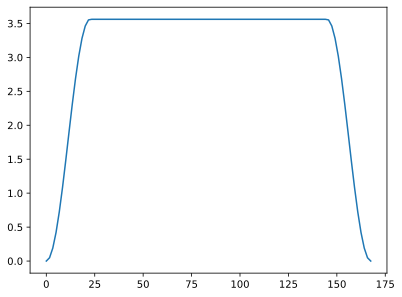

In [4]:
fig, ax = plt.subplots()
tlist = np.linspace(0, 122.5+22.5+22.5, 101)
pulse_shape = []
for t in tlist:
    pulse_shape.append(square_pulse_with_rise_fall(t,{
            "w_d":  0,    # No extra 2pi factor
            "amp": 0.56679488,    # No extra 2pi factor
            't_square': 122.5,
            "t_rise": 22.5,
        }))

ax.plot(tlist, pulse_shape)


In [9]:
# load results_perturbed.json
with open("results_perturbed.json", "r") as f:
    results = [json.loads(line) for line in f]

# If there are duplicate t_tot, keep the one with the lowest fun. If fun is not available, compute it.
unique_t_tot = {}
for result in results:
    if result["t_tot"] not in unique_t_tot:
        unique_t_tot[result["t_tot"]] = result
        if "fun" not in result:
            fun = do_experiment(result["amp"], result["w_d"], result["t_tot"]*0.85, result["t_tot"]*0.15)
            result["fun"] = fun
    else: # (result["t_tot"] in unique_t_tot)
        if "fun" in result:
            if result["fun"] < unique_t_tot[result["t_tot"]]["fun"]:
                unique_t_tot[result["t_tot"]] = result
        else:
            fun = do_experiment(result["amp"], result["w_d"], result["t_tot"]*0.85, result["t_tot"]*0.15)
            result["fun"] = fun
            if result["fun"] < unique_t_tot[result["t_tot"]]["fun"]:
                unique_t_tot[result["t_tot"]] = result

In [10]:
# Store to new json
with open("results_unique.json", "w") as f:
    for result in unique_t_tot.values():
        json.dump(result, f)
        f.write("\n")

In [18]:
# load unique_t_tot
with open("results_unique.json", "r") as f:
    results = [json.loads(line) for line in f]
unique_t_tot = {}
for result in results:
    if result["t_tot"] not in unique_t_tot:
        unique_t_tot[result["t_tot"]] = result
        if "fun" not in result:
            fun = do_experiment(result["amp"], result["w_d"], result["t_tot"]*0.85, result["t_tot"]*0.15)
            result["fun"] = fun
    else: # (result["t_tot"] in unique_t_tot)
        if "fun" in result:
            if result["fun"] < unique_t_tot[result["t_tot"]]["fun"]:
                unique_t_tot[result["t_tot"]] = result
        else:
            fun = do_experiment(result["amp"], result["w_d"], result["t_tot"]*0.85, result["t_tot"]*0.15)
            result["fun"] = fun
            if result["fun"] < unique_t_tot[result["t_tot"]]["fun"]:
                unique_t_tot[result["t_tot"]] = result    

0.045978475980956834

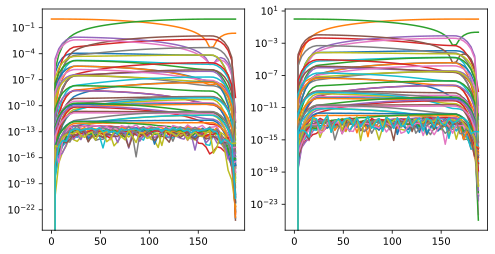

In [11]:
do_experiment(0.5396149582964659, 8.825762401667869e-06, 163.5*0.85, 163.5*0.15,plot=True)

In [20]:
# def objective(amp, w_d, t_tot,t_rise_ratio):
#     t_square = t_tot * (1 - 2 * t_rise_ratio)
#     t_rise = t_tot * t_rise_ratio
#     tlist = np.linspace(0, t_tot, 51)

#     results = qbt.run_qutip_mesolve_parrallel(
#                 initial_states,
#                 [tlist],
#                 drive_terms=[[
#                             DriveTerm(
#                                 driven_op=qutip.Qobj(
#                                     qbt.fluxonium.n_operator(energy_esys=True)),
#                                 pulse_shape_func=square_pulse_with_rise_fall,
#                                 pulse_id='pi',
#                                 pulse_shape_args={
#                                     "w_d": w_d,    # No extra 2pi factor
#                                     "amp": amp,    # No extra 2pi factor
#                                     't_square': t_square,
#                                     "t_rise": t_rise,
#                                 },
#                             )
#                         ]],
#                 c_ops=None,
#                 e_ops=[e_ops],
#                 )[0]

#     one_minus_pop2 = np.abs(1- results[0].expect[2][-1])
#     one_minus_pop0 = np.abs(1- results[1].expect[1][-1])
#     res = one_minus_pop2 + one_minus_pop0
#     print(f"t_tot: {t_tot}, fun: {res}, amp: {amp}, w_d: {w_d}, t_rise_ratio: {t_rise_ratio}")
#     return res


from IPython.display import clear_output


for t_tot in unique_t_tot:

    def objective_with_grad(x):
        amp, w_d = x

        epsilon = 1e-3
        t_rise_ratio = 0.15
        t_square = t_tot * (1 - 2 * t_rise_ratio)
        t_rise = t_tot * t_rise_ratio
        tlist = np.linspace(0, t_tot, 51)

        delta_amp = abs(amp*epsilon)
        amp_forward = amp + delta_amp
        amp_backward = amp - delta_amp
        delta_w_d = abs(w_d*epsilon)
        w_d_forward = w_d + delta_w_d
        w_d_backward = w_d - delta_w_d

        results_five_by_two = qbt.run_qutip_mesolve_parrallel(
                    initial_states,
                    [tlist for _ in range(5)],
                    drive_terms=[[ DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp_forward,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d,
                                        "amp": amp_backward,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d_forward,
                                        "amp": amp,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    },)],
                            [DriveTerm(
                                    driven_op=qutip.Qobj(
                                        qbt.fluxonium.n_operator(energy_esys=True)),
                                    pulse_shape_func=square_pulse_with_rise_fall,
                                    pulse_id='pi',
                                    pulse_shape_args={
                                        "w_d": w_d_backward,
                                        "amp": amp,
                                        't_square': t_square,
                                        "t_rise": t_rise,
                                    }, )]
                            ],
                    c_ops=None,
                    e_ops=[e_ops for _ in range(5)],
                    )

        grad = np.zeros_like(x, dtype=float)

        obj_val = np.zeros((5,))
        for i, results in enumerate(results_five_by_two):
            one_minus_pop2 = np.abs(1- results[0].expect[2][-1])
            one_minus_pop0 = np.abs(1- results[1].expect[1][-1])
            res = one_minus_pop2 + one_minus_pop0
            obj_val[i] = res
        # print(obj_val)
        grad[0] = (obj_val[2] - obj_val[1]) / (2 * delta_amp)  
        grad[1] = (obj_val[4] - obj_val[3]) / (2 * delta_w_d)
        print(f"t_tot: {t_tot}, fun: {obj_val[0]}, amp: {amp}, w_d: {w_d}, t_rise_ratio: {t_rise_ratio}")
        return obj_val[0], -grad

    def manual_nadam(x0, learning_rates, num_iterations=100, stop_threshold=1e-5, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Initialize parameters
        x = np.array(x0, dtype=np.float32)
        m = np.zeros_like(x)  # First moment (mean of gradients)
        v = np.zeros_like(x)  # Second moment (uncentered variance of gradients)
        t = 0  # Time step

        prev_loss = np.inf  # Store the loss value from the previous iteration
        for i in range(num_iterations):
            t += 1
            # Get the objective value and gradient
            obj_val, grad = objective_with_grad(x)

            # Update biased first and second moment estimates
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * grad**2

            # Compute bias-corrected first and second moment estimates
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)

            # Apply Nesterov momentum
            m_nesterov = beta1 * m_hat + (1 - beta1) * grad

            # Update parameters with different learning rates
            x = x - learning_rates * m_nesterov / (np.sqrt(v_hat) + epsilon)

            # Check if the gradient is small enough to stop (optional condition)
            grad_norm = np.linalg.norm(grad)
            if grad_norm < stop_threshold:
                print(f"Stopping early: Gradient norm {grad_norm} is below threshold.")
                break

            # Check if the loss is changing too slowly (convergence)
            loss_diff = np.abs(prev_loss - obj_val)
            if loss_diff < stop_threshold:
                print(f"Stopping early: Loss difference {loss_diff} is below threshold.")
                break

            # Update the previous loss
            prev_loss = obj_val

        return x, prev_loss  # Final optimized values
    
    dictionary = unique_t_tot[t_tot]
    fun_old = dictionary["fun"]
    x0 = [dictionary["amp"], dictionary["w_d"]]
    
    optimized_params, prev_loss = manual_nadam(x0, np.array([0.001,1e-4]), num_iterations=90)
    last_amp, last_w_d = optimized_params
    
    if prev_loss < fun_old:
        #Append result to file
        with open("results_perturbed.json", "a") as f:
            json.dump({
                "t_tot": float(t_tot),
                "amp": float(last_amp),
                "w_d": float(last_w_d),
                'fun': float(prev_loss)
            }, f)
            f.write("\n")

        #print result
        # clear_output(wait=True)
        print(f"t_tot: {t_tot}, fun: {prev_loss}, amp: {last_amp}, w_d: {last_w_d}")

t_tot: 171.5, fun: 0.001481475454252812, amp: 0.5378928780555725, w_d: 4.041562988277292e-06, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.00149421911627301, amp: 0.5388927546819862, w_d: -9.595834120960482e-05, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.0014822811331854924, amp: 0.5380897169442767, w_d: -1.887425937203318e-05, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.001495919869571427, amp: 0.5372076667965161, w_d: 4.2495296465538336e-05, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.0014819041090133878, amp: 0.5377280218206093, w_d: -6.681777398236333e-07, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.0014826339830561475, amp: 0.5381337014166951, w_d: -2.1569592235599398e-05, t_rise_ratio: 0.15
Stopping early: Loss difference 7.298740427597039e-07 is below threshold.
t_tot: 170.5, fun: 0.002618660238553616, amp: 0.53822261095047, w_d: 3.846146228170255e-06, t_rise_ratio: 0.15
t_tot: 170.5, fun: 0.002694424268341211, amp: 0.537222614431591, w_d: 0.00010384614621199143, t_rise_ratio: 0.15
t_tot: 170.5, fu

KeyboardInterrupt: 

In [25]:
# # Load and plot results
# with open("results_perturbed.json", "r") as f:
#     results = [json.loads(line) for line in f]

# # Run the evolution with the optimized parameters
# for result in results:
#     t_tot = result["t_tot"]
#     amp = result["amp"]
#     w_d = result["w_d"]
#     fun = objective(amp, w_d, t_tot, 0.15)
#     print(f"t_tot: {t_tot}, fun: {fun}, amp: {amp}, w_d: {w_d}")


t_tot: 171.5, fun: 0.00310611021404239, amp: 0.5668121077950674, w_d: 0.00047675516216389845, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.00310611021404239, amp: 0.5668121077950674, w_d: 0.00047675516216389845
t_tot: 171.5, fun: 0.00310611021404239, amp: 0.5668121077950674, w_d: 0.00047675516216389845, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.00310611021404239, amp: 0.5668121077950674, w_d: 0.00047675516216389845
t_tot: 171.5, fun: 0.0016239856799165064, amp: 0.5453551360562728, w_d: 0.00028763, t_rise_ratio: 0.15
t_tot: 171.5, fun: 0.0016239856799165064, amp: 0.5453551360562728, w_d: 0.00028763
t_tot: 170.5, fun: 0.0026554795741592363, amp: 0.5398997793568229, w_d: 0.00014381499999996522, t_rise_ratio: 0.15
t_tot: 170.5, fun: 0.0026554795741592363, amp: 0.5398997793568229, w_d: 0.00014381499999996522
t_tot: 169.5, fun: 0.004086246698902007, amp: 0.5387888444476463, w_d: 7.190749999998609e-05, t_rise_ratio: 0.15
t_tot: 169.5, fun: 0.004086246698902007, amp: 0.5387888444476463, w_d: 7.190749